In [ ]:
### To-Do
# X) work out math if extra treatment needed for lumi normalization
# 1) plot some variables before and after normalization. how do they compare?
# X) try batch normalization in the network? re-do step1 maybe?
# 3) to_categorical for signal and background preds?
# 4) grid optimization? --> dropout rate, layers, nodes, etc
# X) k-fold validation

In [38]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.regularizers import l2, l1
from keras.utils import normalize, to_categorical
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [2]:
import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

In [3]:
#*** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

# *** 2. Make mix of dihiggs and QCD for specified variables
#variables_top10 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
variables_top10 = list(qcd_raw.columns.values)
variables_top10.remove('isSignal')
variables_top10.remove('isMatchable')

top10_data_train, top10_data_test, top10_labels_train, top10_labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables_top10, testingFraction)


N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [5]:
# *** 2. Split testing data and normalize data inputs
top10_data_train__norm = normalize(top10_data_train, axis=1)
top10_data_test__norm = normalize(top10_data_test, axis=1)

#top10_labels_train = to_categorical(top10_labels_train)
#top10_labels_test = to_categorical(top10_labels_test)

In [61]:
# *** 3A. Define NN model and train
nInputNodes = len(top10_data_train__norm.columns) # = 53 for all variables, other configurations will vary

model = Sequential()
model.add(Dense(100, input_dim=nInputNodes, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(1, activation='sigmoid', activity_regularizer=l1(0.001)))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#history = model.fit(top10_data_train__norm, top10_labels_train, epochs=50, validation_split=0.25, batch_size=400)
history = model.fit(top10_data_train__norm, top10_labels_train, epochs=15, validation_data=(top10_data_test__norm, top10_labels_test), batch_size=400)


Train on 136749 samples, validate on 58608 samples
Epoch 1/15
136749/136749 [==============================] - 3s 19us/step - loss: 0.5936 - accuracy: 0.6699 - val_loss: 0.6208 - val_accuracy: 0.6875
Epoch 2/15
136749/136749 [==============================] - 2s 17us/step - loss: 0.5590 - accuracy: 0.7024 - val_loss: 0.5447 - val_accuracy: 0.7180
Epoch 3/15
136749/136749 [==============================] - 3s 20us/step - loss: 0.5257 - accuracy: 0.7335 - val_loss: 0.5029 - val_accuracy: 0.7492
Epoch 4/15
136749/136749 [==============================] - 2s 18us/step - loss: 0.5020 - accuracy: 0.7523 - val_loss: 0.4918 - val_accuracy: 0.7586
Epoch 5/15
136749/136749 [==============================] - 2s 18us/step - loss: 0.4890 - accuracy: 0.7626 - val_loss: 0.4745 - val_accuracy: 0.7725
Epoch 6/15
136749/136749 [==============================] - 3s 20us/step - loss: 0.4795 - accuracy: 0.7706 - val_loss: 0.4674 - val_accuracy: 0.7773
Epoch 7/15
136749/136749 [=============================

In [8]:
#plt.hist( hh_raw.nJets, bins=10)
diff = [x for x in top10_data_test__norm if x not in top10_data_train__norm]


In [ ]:
# *** 3B. Define k-fold NN model and train
nInputNodes = len(top10_data_train__norm.columns) # = 53 for all variables, other configurations will vary
kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
crossVal_scores = []

X = np.array(top10_data_train__norm)
Y = np.array(top10_labels_train)

for train, test in kFold.split(X, Y):
  # create model
    k_model = Sequential()
    k_model.add(Dense(50, input_dim= nInputNodes, activation='relu'))
    #k_model.add(Dropout(0.2))
    k_model.add(BatchNormalization())

    k_model.add(Dense(25, activation='relu'))
    k_model.add(Dense(12, activation='relu'))
    #k_model.add(Dense(8, activation='relu'))
    k_model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    k_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit the model
    k_model.fit(X[train], Y[train], epochs=50, batch_size=400, verbose=0)
    
    # Evaluate the model
    scores = k_model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (k_model.metrics_names[1], scores[1]*100))
    crossVal_scores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(crossVal_scores), np.std(crossVal_scores)))

In [62]:
# *** 4. Do some very specific evaluation based on pure samples
hh_data_test, hh_labels_test, qcd_data_test, qcd_labels_test = returnTestSamplesSplitIntoSignalAndBackground(top10_data_test__norm, top10_labels_test)

#top10_data_test__norm['isSignal'] = top10_labels_test
#hh_data_test = top10_data_test__norm[ top10_data_test__norm.isSignal==1 ]
#qcd_data_test = top10_data_test__norm[ top10_data_test__norm.isSignal==0 ]
#hh_labels_test = hh_data_test.isSignal
#qcd_labels_test = qcd_data_test.isSignal
#hh_data_test = hh_data_test.drop('isSignal', axis=1)
#qcd_data_test = qcd_data_test.drop('isSignal', axis=1)

score_hh = model.evaluate(hh_data_test, hh_labels_test)
score_qcd = model.evaluate(qcd_data_test, qcd_labels_test)
print(score_hh, score_qcd)
pred_hh = model.predict(hh_data_test)
pred_qcd = model.predict(qcd_data_test)

34884/34884 [==============================] - 1s 30us/step
[0.6063477179288985, 0.6751391291618347] [0.31668279417821976, 0.8809196352958679]


In [63]:
model.count_params()
#model_confusionMatrix = confusion_matrix(hh_data_test, hh_labels_test)
#print(cm)


20651

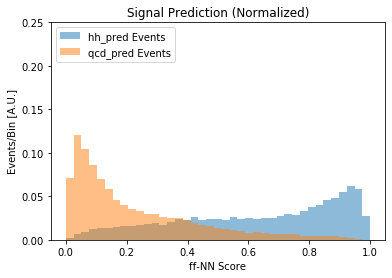

In [64]:
_nBins = 40
predictionResults = {'hh_pred':pred_hh, 'qcd_pred':pred_qcd}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'ff-NN Score', 0, 1, _nBins, _yMax = 5, _normed=True, _savePlot=False )


In [65]:
# *** 4. Get best cut value for ff-NN assuming some minimal amount of signal
returnBestCutValue('ff-NN', pred_hh.copy(), pred_qcd.copy(), _minBackground=400e3, _testingFraction=testingFraction)

23724 34884
nSig = [1192.74] , nBkg = [488261.93] with significance = [1.70694431] for ff-NN score > [0.8965132]


(array([1.70694431]), array([0.8965132], dtype=float32))

In [ ]:
# *** 5. Get signifiance for any user-specified NN score cut value
lumiscale_hh  = getLumiScaleFactor(testingFraction, True)
lumiscale_qcd = getLumiScaleFactor(testingFraction, False)
cut = 0.87
_nSignal = sum( value > cut for value in pred_hh)*lumiscale_hh
_nBackground = sum( value > cut for value in pred_qcd)*lumiscale_qcd

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

In [ ]:
import pickle
pickle.dump(model, open('models/allVars_100-50-50.pkl', 'wb'))


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


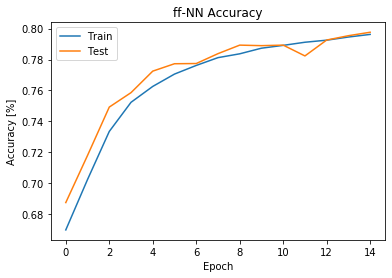

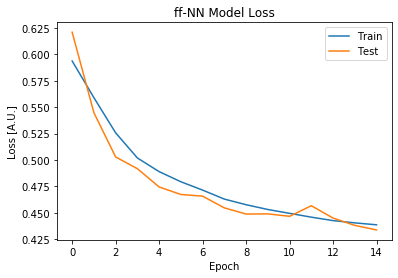

In [66]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ff-NN Accuracy')
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ff-NN Model Loss')
plt.ylabel('Loss [A.U.]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               12600     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 20,651
Trainable params: 20,451
Non-trainable params: 200
_________________________________________________________________


In [34]:
# ROC curve and AUC
top10_data_test_ROC = top10_data_test__norm.copy()
#top10_data_test_ROC = top10_data_test_ROC.drop('isSignal', axis=1)

y_pred = model.predict(top10_data_test_ROC).ravel()
falsePositiveRate, truePositiveRate, thresholds = roc_curve(top10_labels_test, y_pred)
auc_keras = auc(falsePositiveRate, truePositiveRate)

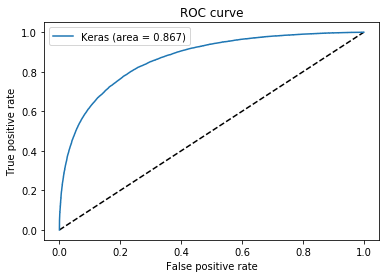

In [35]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(falsePositiveRate, truePositiveRate, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()